In [1]:
from collections import namedtuple
from dataclasses import dataclass, replace
import cvxopt
import numpy as np
from matplotlib import pyplot

from donotation import do

import statemonad

import polymat
from polymat.typing import (
    State,
    MatrixExpression,
    VariableExpression,
)

import sosopt
from sosopt.typing import PolynomialVariable, SolverResult
from sosopt import define_polynomial_variable

In [2]:
@dataclass
class ModelParam:
    s_b: float
    w_n: float

    v_grid_phph: float
    r_grid_si: float
    l_grid_si: float

    r_tr: float
    x_tr: float

    c_dc_si: float
    r_dc_si: float
    v_dc_b: float

    def __post_init__(self):
        self.v_b = self.v_grid_phph / np.sqrt(3)
        self.i_b = self.s_b / self.v_b
        self.z_b = self.v_b**2 / self.s_b
        self.l_b = self.z_b / self.w_n
        self.z_dc_b = self.v_dc_b**2 / self.s_b
        self.c_dc_b = 1 / (self.z_dc_b * self.w_n)

        self.r_grid = self.r_grid_si / self.z_b
        self.x_grid = self.l_grid_si / self.l_b
        self.c_dc = self.c_dc_si / self.c_dc_b
        self.r_dc = self.r_dc_si / self.z_dc_b

        self.g_dc = 1 / self.r_dc

        self.l = self.x_tr + self.x_grid


model = ModelParam(
    s_b=20e6 / 3,
    w_n=2 * np.pi * 50,
    v_grid_phph=130e3,
    r_grid_si=1e-3,
    l_grid_si=0.01,
    r_tr=2 * 3e-3,
    x_tr=2 * 9e-2,
    c_dc_si=2 * 10e-3,
    r_dc_si=1000,
    v_dc_b=2400,
)

In [3]:
state = polymat.init_state()
solver = sosopt.cvx_opt_solver
# solver = sosopt.mosek_solver

u_degrees = (0, 1, 2, 3)
V_degrees = (0, 1, 2, 3, 4)
B_degrees = (1, 2, 3, 4)


# variables
###########

variable_names = ("v_dc", "i_d", "i_q")
v_dc, i_d, i_q = tuple(polymat.define_variable(name) for name in variable_names)

x = polymat.v_stack((v_dc, i_d, i_q))
n_states = 3

# control model
###############


scale = np.diag((1 / model.c_dc, 1 / model.l, 1 / model.l)) * model.w_n

f = polymat.from_(scale @ np.array((
    (-model.g_dc*v_dc - i_d + model.g_dc*model.l*i_q,),
    (v_dc + model.l*i_q,),
    (-model.g_dc*model.l*v_dc - model.l*i_d,),
)))

G = polymat.from_(scale @ np.array((
    (model.g_dc-i_d, -i_q), 
    (1+v_dc, 0), 
    (0, 1+v_dc),
)))

# control model
###############

w1 = ((v_dc + 0.3) / 0.5) ** 2 + (i_d / 20) ** 2 + (i_q / 20) ** 2 - 1
w2 = ((v_dc + 0.3) / 20) ** 2 + (i_d / 1.3) ** 2 + (i_q / 1.3) ** 2 - 1


p_monom = x.combinations(degrees=u_degrees)
p = define_polynomial_variable(
    name="p", 
    monomials=p_monom, 
    polynomial_variables=x,
    n_row=2
)

G_at_p = (G @ p).cache()

state, max_degrees = polymat.to_degree(G_at_p, variables=x).apply(state)
max_degree: int = int(np.max(max_degrees))

state, s = sosopt.define_multiplier(
    name="s",
    degree=max_degree,
    multiplicand=f,
    variables=x,
).apply(state)

x_dot = (s * f + G_at_p).cache()

# Control Lyapunov and Barrier Functions
################################

V_monom = x.combinations(degrees=V_degrees)
V = define_polynomial_variable(
    name="V", 
    monomials=V_monom, 
    polynomial_variables=x,
)
dV = V.diff(x).T.cache()

B1_monom = x.combinations(degrees=B_degrees)
B1_var = define_polynomial_variable(
    name="B1", 
    monomials=B1_monom, 
    polynomial_variables=x,
)
B1 = B1_var - 1
dB1 = B1.diff(x).T.cache()

B2_monom = x.combinations(degrees=B_degrees)
B2_var = define_polynomial_variable(
    name="B2", 
    monomials=B2_monom, 
    polynomial_variables=x,
)
B2 = B2_var - 1
dB2 = B2.diff(x).T.cache()

# region of interest
####################

epsilon_roi_V = sosopt.define_variable(name="epsilon_roi_V")
epsilon_roi_B = sosopt.define_variable(name="epsilon_roi_B")

roi = (
    1.0 - (0.259537750205392 * i_d**2 + 0.259537750205392 * i_q**2 + 3.50960314067544 * v_dc**2 + 2.10573558538538 * v_dc)
).cache()
roi_V = roi - epsilon_roi_V
roi_B = roi - epsilon_roi_B


# nominal controller
####################

u_nom = polymat.from_(np.array((
    ((0.1*v_dc - i_d),),
    ((0 - i_q),),
)))

x_n_dot = f + G @ u_nom


# decrease rate
###############

decrease_rate = 0.01 * s * roi * (V + 1)


# Margins
#########

clf_epsilon = sosopt.define_variable(name="clf_epsilon")
cbf1_epsilon = sosopt.define_variable(name="cbf1_epsilon")
cbf2_epsilon = sosopt.define_variable(name="cbf2_epsilon")

In [4]:
@do()
def define_constraints():

    clf_condition = yield from sosopt.sos_constraint_putinar(
        name="clf",
        greater_than_zero=-(dV.T @ x_dot) - decrease_rate + clf_epsilon,
        domain=sosopt.set_(
            greater_than_zero={"V": V, "roi": roi_V},
        ),
    )

    clf_unom_condition = yield from sosopt.sos_constraint_putinar(
        name="unom",
        greater_than_zero=-(dV.T @ x_n_dot), # -decrease_rate,
        domain=sosopt.set_(
            greater_than_zero={"roi": roi_V},
            equal_zero={"V": V},
        ),
    )

    cbf1_condition = yield from sosopt.sos_constraint_putinar(
        name="cbf1",
        greater_than_zero=-(dB1.T @ x_dot) + cbf1_epsilon,
        domain=sosopt.set_(
            greater_than_zero={"roi": roi_B},
            equal_zero={"B": B1},
        ),
    )

    cbf2_condition = yield from sosopt.sos_constraint_putinar(
        name="cbf2",
        greater_than_zero=-(dB2.T @ x_dot) + cbf2_epsilon,
        domain=sosopt.set_(
            greater_than_zero={"roi": roi_B},
            equal_zero={"B": B2},
        ),
    )

    b1_contains_v = yield from sosopt.sos_constraint(
        name="b1v",
        greater_than_zero=V - B1,
    )

    b2_contains_v = yield from sosopt.sos_constraint(
        name="b2v",
        greater_than_zero=V - B2,
    )
    
    w1_contains_b1 = yield from sosopt.sos_constraint_putinar(
        name="b1w1",
        greater_than_zero=B1,
        domain=sosopt.set_(
            greater_than_zero={"w": w1},
        ),
    )

    w2_contains_b2 = yield from sosopt.sos_constraint_putinar(
        name="b2w2",
        greater_than_zero=B2,
        domain=sosopt.set_(
            greater_than_zero={"w": w2},
        ),
    )

    s_positive = yield from sosopt.sos_constraint(
        name="spos",
        greater_than_zero=s - 0.001,
    )

    epsilon_roiV = yield from sosopt.sos_constraint(
        name="epsilon_roiV",
        greater_than_zero=epsilon_roi_V,
    )

    epsilon_roiB = yield from sosopt.sos_constraint(
        name="epsilon_roiB",
        greater_than_zero=epsilon_roi_B,
    )

    min_margin = 0.01
    epsilon_clf = yield from sosopt.sos_constraint(
        name="epsilon_clf",
        greater_than_zero=clf_epsilon - min_margin,
    )
    
    epsilon_cbf1 = yield from sosopt.sos_constraint(
        name="epsilon_cbf1",
        greater_than_zero=cbf1_epsilon - min_margin,
    )
    
    epsilon_cbf2 = yield from sosopt.sos_constraint(
        name="epsilon_cbf2",
        greater_than_zero=cbf2_epsilon - min_margin,
    )

    constraints = (
        clf_condition,
        clf_unom_condition,
        cbf1_condition,
        cbf2_condition,

        w1_contains_b1,
        w2_contains_b2,
        b1_contains_v,
        b2_contains_v,
        
        s_positive,
        
        epsilon_roiV,
        epsilon_roiB,
        
        epsilon_clf,
        epsilon_cbf1,
        epsilon_cbf2,
    )
    constraints_dict = {c.name: c for c in constraints}
    # constraint_tuple = namedtuple('Constraints', constraints_dict.keys())(**constraints_dict)

    return statemonad.from_[State](constraints_dict)

state, constraints = define_constraints().apply(state)

In [5]:
@do()
def define_initial_guess():
    p0 = (polymat.from_(-np.ones((2, 3))) @ x)

    init_values = (
        (p, p0),
        (s, 100),
        (constraints['clf'].multipliers["V"], 100),
        (constraints['unom'].multipliers["V"], 100),
        (constraints['cbf1'].multipliers["B"], 100),
        (constraints['cbf2'].multipliers["B"], 100),
        (epsilon_roi_V, 1),
        (epsilon_roi_B, 1),
    )

    def to_tuple():
        for expr, value_expr in init_values:
            if isinstance(value_expr, (float, int)):
                value_expr = polymat.from_vector(value_expr)

            @do()
            def to_symbol_data_tuple(expr, symbol, monomials=None):
                data = yield from polymat.to_tuple(
                    expr.linear_in(variables=x, monomials=monomials)
                )
                return statemonad.from_((symbol, data[0]))                
            
            match expr:
                case PolynomialVariable(monomials=monomials):
                    for (row, col), param in expr.iterate_coefficients():
                        yield to_symbol_data_tuple(
                            expr=value_expr[row, col],
                            symbol=param.symbol,
                            monomials=monomials,
                        )

                case VariableExpression() as var_expr:
                    yield to_symbol_data_tuple(
                        expr=value_expr,
                        symbol=var_expr.symbol,
                    )

    values_tuple = yield from statemonad.zip(to_tuple())

    values = dict(values_tuple)

    return statemonad.from_[State](values)

state, inital_values = define_initial_guess().apply(state)

In [6]:
@dataclass
class IterationData:
    state: State
    values: dict
    solver_data: SolverResult | None

iter_data = IterationData(
    state=state,
    values=inital_values,
    solver_data=None,
)

In [7]:
@dataclass
class Step:
    lin_cost: MatrixExpression
    quad_cost: MatrixExpression | None
    substitutions: tuple
    values_overwrite: dict

def init_step(
    lin_cost: MatrixExpression,
    substitutions: tuple,
    quad_cost: MatrixExpression | None = None,
    values_overwrite: dict = {},
):
    return Step(
        lin_cost=lin_cost, 
        quad_cost=quad_cost, 
        substitutions=substitutions, 
        values_overwrite=values_overwrite,
    )

set_epsilon_to_zero = {
    clf_epsilon.symbol: (0,),
    cbf1_epsilon.symbol: (0,),
    cbf2_epsilon.symbol: (0,),
}

step_1_margin = init_step(
    lin_cost=clf_epsilon + cbf1_epsilon + cbf2_epsilon,
    substitutions=(
        epsilon_roi_V, epsilon_roi_B, 
        p, s,
        constraints['clf'].multipliers["V"],
        constraints['unom'].multipliers["V"],
        constraints['cbf1'].multipliers["B"],
        constraints['cbf2'].multipliers["B"],
    )
)

step_1_roiV = init_step(
    lin_cost=epsilon_roi_V,
    substitutions=(
        epsilon_roi_B, 
        p, s,
        constraints['clf'].multipliers["V"], constraints['clf'].multipliers["roi"],
        constraints['unom'].multipliers["V"], constraints['unom'].multipliers["roi"],
        constraints['cbf1'].multipliers["B"],
        constraints['cbf2'].multipliers["B"],
        clf_epsilon, cbf1_epsilon, cbf2_epsilon,
    ),
    values_overwrite=set_epsilon_to_zero,
)

step_1_roiB = init_step(
    lin_cost=epsilon_roi_B,
    substitutions=(
        epsilon_roi_V,
        p, s,
        constraints['clf'].multipliers["V"],
        constraints['unom'].multipliers["V"],
        constraints['cbf1'].multipliers["B"], constraints['cbf1'].multipliers["roi"],
        constraints['cbf2'].multipliers["B"], constraints['cbf2'].multipliers["roi"],
        clf_epsilon, cbf1_epsilon, cbf2_epsilon,
    ),
    values_overwrite=set_epsilon_to_zero,
)

step_1_vol = init_step(
    lin_cost=sosopt.to_gram_matrix(B1, x).trace() + sosopt.to_gram_matrix(B2, x).trace(),
    substitutions=(
        epsilon_roi_V, epsilon_roi_B,
        p, s,
        constraints['clf'].multipliers["V"],
        constraints['unom'].multipliers["V"],
        constraints['cbf1'].multipliers["B"],
        constraints['cbf2'].multipliers["B"],
        clf_epsilon, cbf1_epsilon, cbf2_epsilon,
    ),
    values_overwrite=set_epsilon_to_zero,
)

step_2_margin = init_step(
    lin_cost=clf_epsilon + cbf1_epsilon + cbf2_epsilon,
    substitutions=(
        epsilon_roi_V, epsilon_roi_B, 
        V, B1_var, B2_var,
    )
)

step_2_roiV = init_step(
    lin_cost=epsilon_roi_V,
    substitutions=(
        epsilon_roi_B, 
        V, B1_var, B2_var,
        constraints['clf'].multipliers["roi"],
        constraints['unom'].multipliers["roi"],
        clf_epsilon, cbf1_epsilon, cbf2_epsilon,
    ),
    values_overwrite=set_epsilon_to_zero,
)

step_2_roiB = init_step(
    lin_cost=epsilon_roi_B,
    substitutions=(
        epsilon_roi_V, 
        V, B1_var, B2_var,
        constraints['cbf1'].multipliers["roi"],
        constraints['cbf2'].multipliers["roi"],
        clf_epsilon, cbf1_epsilon, cbf2_epsilon,
    ),
    values_overwrite=set_epsilon_to_zero,
)

In [8]:
@do()
def solve_problem(step: Step, iter_data: IterationData):
    problem = sosopt.sos_problem(
        lin_cost=step.lin_cost,
        quad_cost=step.quad_cost,
        constraints=constraints.values(),
        solver=solver,
    )

    # overwrite values
    values = iter_data.values | step.values_overwrite

    # filter values that need to be substituted
    problem = problem.eval({
        symbol: values[symbol] for param in step.substitutions for symbol in param.to_symbols()
    })

    # for primitive in problem.constraint_primitives:
    #     print(f'{primitive.name=}, {primitive.decision_variable_symbols=}')

    solver_data, n_values = yield from problem.solve()
    
    n_iter_data = replace(iter_data, values=values | n_values, solver_data=solver_data)
    
    print(f'{solver_data.status=}, {solver_data.iterations=}, {solver_data.cost=}')

    epsilon_roi = (clf_epsilon, cbf1_epsilon, cbf2_epsilon, epsilon_roi_V, epsilon_roi_B)
    print(tuple(n_iter_data.values[e.symbol] for e in epsilon_roi))

    return statemonad.from_(n_iter_data)

In [11]:
cvxopt.solvers.options['show_progress'] = False
# cvxopt.solvers.options['show_progress'] = True

cvxopt.solvers.options['maxiters'] = 100

for idx in range(20):
    print(f'iteration: {idx}')
        
    if 1e-6 < iter_data.values[epsilon_roi_B.symbol][0]:
        state, iter_data = solve_problem(step_1_margin, iter_data).apply(state)
        state, iter_data = solve_problem(step_1_roiB, iter_data).apply(state)
    
    if 1e-6 < iter_data.values[epsilon_roi_V.symbol][0]:
        state, iter_data = solve_problem(step_2_margin, iter_data).apply(state)
        state, iter_data = solve_problem(step_2_roiV, iter_data).apply(state)

        state, iter_data = solve_problem(step_1_margin, iter_data).apply(state)
        state, iter_data = solve_problem(step_1_roiV, iter_data).apply(state)
    else:
        break
    
    if 1e-6 < iter_data.values[epsilon_roi_B.symbol][0]:
        state, iter_data = solve_problem(step_2_margin, iter_data).apply(state)
        state, iter_data = solve_problem(step_2_roiB, iter_data).apply(state)

print('start maximizing the volume')

for idx in range(5):
    print(f'iteration: {idx}')

    state, iter_data = solve_problem(step_2_margin, iter_data).apply(state)
    state, iter_data = solve_problem(step_1_vol, iter_data).apply(state)

iteration: 0
start maximizing the volume
iteration: 0
solver_data.status='optimal', solver_data.iterations=16, solver_data.cost=0.030000000000213915
((0.010000000000070857,), (0.010000000000071037,), (0.010000000000072016,), (1.5182463966368234e-10,), (-6.051216005296295e-14,))
solver_data.status='optimal', solver_data.iterations=23, solver_data.cost=9.694728500268917
((0,), (0,), (0,), (1.5182463966368234e-10,), (-6.051216005296295e-14,))
iteration: 1
solver_data.status='optimal', solver_data.iterations=15, solver_data.cost=0.03000000000248395
((0.010000000000834708,), (0.010000000000815662,), (0.01000000000083358,), (1.5182463966368234e-10,), (-6.051216005296295e-14,))
solver_data.status='optimal', solver_data.iterations=24, solver_data.cost=6.496882405411973
((0,), (0,), (0,), (1.5182463966368234e-10,), (-6.051216005296295e-14,))
iteration: 2
solver_data.status='optimal', solver_data.iterations=17, solver_data.cost=0.030000000000634484
((0.010000000000211617,), (0.010000000000211258

In [13]:
@do()
def dostuff():
    # expr = V.eval(iter_data.values)
    # expr = sosopt.to_gram_matrix(epsilon_roi_V, polymat.from_variable_indices(tuple()))

    expr = constraints['clf'].multipliers["V"]
    expr = V
    expr = decrease_rate
    
    func = yield polymat.to_array(expr.eval(iter_data.values), x)
    print('eval')
    print(f'{func((0.1, 0, 0))=}')

    return statemonad.from_(None)

_ = dostuff().apply(state)

eval
func((0.1, 0, 0))=array([[0.02805284]])


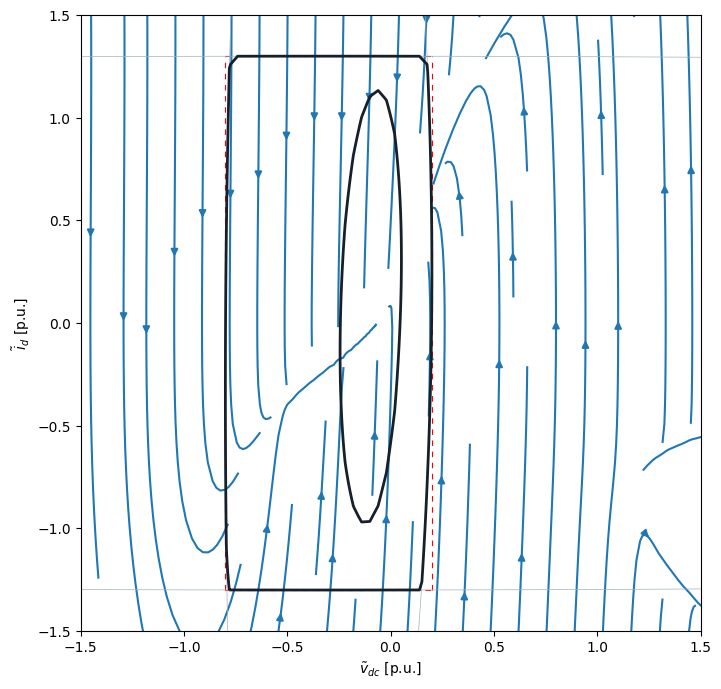

In [13]:
@do()
def plot_result(result):

    f_array = yield from polymat.to_array(f, x)
    G_array = yield from polymat.to_array(G, x)
    p_array = yield from polymat.to_array(p.eval(result), x)
    s_array = yield from polymat.to_array(s.eval(result), x)

    def pend(x, _):
        x = np.array(x).reshape(-1, 1)
    
        u = p_array(x) / s_array(x)
        
        xdot = f_array(x) + G_array(x) @ u
    
        return np.squeeze(xdot)
    
    pyplot.close()
    fig = pyplot.figure(figsize=(8, 8))
    ax = fig.subplots()
    
    x_min, x_max, y_min, y_max = -0.8, 0.2, -1.3, 1.3
    linewidth = 0.8
    dashes = (5, 5)
    ax.plot(np.array((x_min, x_max)), np.array((y_min, y_min)), 'r', linestyle='dashed', dashes=dashes, linewidth=linewidth)
    ax.plot(np.array((x_min, x_max)), np.array((y_max, y_max)), 'r', linestyle='dashed', dashes=dashes, linewidth=linewidth)
    ax.plot(np.array((x_min, x_min)), np.array((y_min, y_max)), 'r', linestyle='dashed', dashes=dashes, linewidth=linewidth)
    ax.plot(np.array((x_max, x_max)), np.array((y_min, y_max)), 'r', linestyle='dashed', dashes=dashes, linewidth=linewidth)

    coord = lambda x, y: (x, y, 0)

    ticksX = np.arange(-2, 2, 0.04)
    ticksY = np.arange(-2, 2, 0.04)
    X = np.matlib.repmat(ticksX, len(ticksY), 1)
    Y = np.matlib.repmat(ticksY, len(ticksX), 1).T

    density_x = 1
    density_y = 1.4
    stream_UV = tuple(tuple(pend(coord(x, y), _) for x, y in zip(x_row, y_row)) for x_row, y_row in zip(X, Y))
    stream_U = np.array(tuple(tuple(e[0] for e in row) for row in stream_UV))
    stream_V = np.array(tuple(tuple(e[1] for e in row) for row in stream_UV))
    ax.streamplot(X, Y, stream_U, stream_V, density=[density_x, density_y])

    ticks = np.arange(-2.1, 2.1, 0.04)
    X = np.matlib.repmat(ticks, len(ticks), 1)
    Y = X.T

    V_array = yield from polymat.to_array(V.eval(result), x)
    ZV = np.vectorize(lambda x, y: V_array(coord(x, y)))(X, Y)
    ax.contour(X, Y, ZV, [0.0], linewidths=2, colors=['#17202A'])

    B1_array = yield from polymat.to_array(B1.eval(result), x)
    ZB1 = np.vectorize(lambda x, y: B1_array(coord(x, y)))(X, Y)
    ax.contour(X, Y, ZB1, [0.0], linewidths=0.5, colors=['#A0B1BA'])

    B2_array = yield from polymat.to_array(B2.eval(result), x)
    ZB2 = np.vectorize(lambda x, y: B2_array(coord(x, y)))(X, Y)
    ax.contour(X, Y, ZB2, [0.0], linewidths=0.5, colors=['#A0B1BA'])
    
    def pick_closest(x, y):   
        v1 = B1_array(coord(x, y))
        v2 = B2_array(coord(x, y))
    
        if v1 < v2:
            return v2
        else:
            return v1
    Zpick = pick_closest_vec = np.vectorize(pick_closest)(X, Y)
    CS = ax.contour(X, Y, Zpick, levels=[0], linewidths=2, colors=['#17202A'])

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    ax.set_xlabel(r'${\tilde v}_{dc}$ [p.u.]')
    ax.set_ylabel(r'${\tilde i}_{d}$ [p.u.]')
    
    pyplot.show()

    return statemonad.from_[State](None)

state, _ = plot_result(iter_data.values).apply(state)